This fairness analysis of COMPAS dataset has been adapted partly from the [COMPAS analysis by Aequitas](https://dssg.github.io/aequitas/examples/compas_demo.html)

## Introduction to fairness and bias analysis
Recent work in the Machine Learning community has raised concerns about the risk of unintended bias in Algorithmic Decision-Making systems, affecting individuals unfairly. While many bias metrics and fairness definitions have been proposed in recent years, the community has not reached a consensus on which definitions and metrics should be used, and there has been very little empirical analyses of real-world problems using the proposed metrics.

## COMPAS Dataset
Northpointe’s COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the most widesly utilized risk assessment tools/ algorithms within the criminal justice system for guiding decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

In [1]:
include("start.jl")
using DataFrames, MLJ, CSV, VegaLite

Activating environment at `~/Desktop/Jul/MLJTutorials/Project.toml`


In [2]:
df = CSV.read("compas-for-aequitas.csv")
df[1:5, :]

,entity_id,score,label_value,race,sex,age_cat
,Int64,Float64,Int64,String,String,String
1,1,0.0,0,Other,Male,Greater than 45
2,3,0.0,1,African-American,Male,25 - 45
3,4,0.0,1,African-American,Male,Less than 25
4,5,1.0,0,African-American,Male,Less than 25
5,6,0.0,0,Other,Male,25 - 45


In [3]:
schema(df)

┌─────────────┬─────────┬────────────┐
│ _.names     │ _.types │ _.scitypes │
├─────────────┼─────────┼────────────┤
│ entity_id   │ Int64   │ Count      │
│ score       │ Float64 │ Continuous │
│ label_value │ Int64   │ Count      │
│ race        │ String  │ Textual    │
│ sex         │ String  │ Textual    │
│ age_cat     │ String  │ Textual    │
└─────────────┴─────────┴────────────┘
_.nrows = 7214


In [4]:
df = coerce(df, Textual=>OrderedFactor)
df = coerce(df, :score=>Count)
schema(df)

┌─────────────┬───────────────────────────┬──────────────────┐
│ _.names     │ _.types                   │ _.scitypes       │
├─────────────┼───────────────────────────┼──────────────────┤
│ entity_id   │ Int64                     │ Count            │
│ score       │ Int64                     │ Count            │
│ label_value │ Int64                     │ Count            │
│ race        │ CategoricalString{UInt32} │ OrderedFactor{6} │
│ sex         │ CategoricalString{UInt32} │ OrderedFactor{2} │
│ age_cat     │ CategoricalString{UInt32} │ OrderedFactor{3} │
└─────────────┴───────────────────────────┴──────────────────┘
_.nrows = 7214


### Levels of recidivism

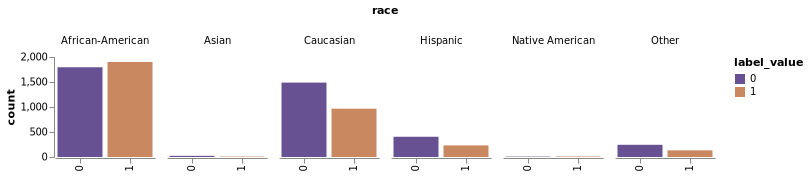

In [5]:
df |>
@vlplot(
    :bar,
    width=100,
    height=100,
    column="race:o",
    y={"count()", axis={title="count", grid=false}},
    x={"label_value:n", axis={title=""}},
    color={"label_value:n", scale={range=["#675193", "#ca8861"]}},
    spacing=10,
    config={
        view={stroke=:transparent},
        axis={domainWidth=1}
    }
)

## Model Training
Now we will train a AdaBoostClassifier to predict the label_value. In this tutorial we will be training only on entity_id, age, sex and race. The actual COMPAS Dataset contains multiple columns. But for simplicity, we will be training only on these 4 values.


### Data Preprocessing

We unpack our dataframe, convert our target labels to categorical. Then we use the Transformer:OneHotEncoder provided by MLJ.

In [6]:
y, X = unpack(df, ==(:label_value), col -> true);

y = categorical(y);

X = X[[:entity_id, :race, :sex, :age_cat]]
X = coerce(X, Count=>Continuous);

X = transform(fit!(machine(OneHotEncoder(), X)), X);

train, test = partition(eachindex(y), 0.7, shuffle=true);

schema(X)

┌ Warning: `getindex(df::DataFrame, col_inds::Union{AbstractVector, Regex, Not})` is deprecated, use `df[:, col_inds]` instead.
│   caller = top-level scope at In[6]:4
└ @ Core In[6]:4
┌ Info: Training Machine{OneHotEncoder} @ 3…69.
└ @ MLJBase /home/ashryaagr/.julia/packages/MLJBase/N04uL/src/machines.jl:164
┌ Info: Spawning 6 sub-features to one-hot encode feature :race.
└ @ MLJModels /home/ashryaagr/.julia/packages/MLJModels/0y2jz/src/builtins/Transformers.jl:588
┌ Info: Spawning 2 sub-features to one-hot encode feature :sex.
└ @ MLJModels /home/ashryaagr/.julia/packages/MLJModels/0y2jz/src/builtins/Transformers.jl:588
┌ Info: Spawning 3 sub-features to one-hot encode feature :age_cat.
└ @ MLJModels /home/ashryaagr/.julia/packages/MLJModels/0y2jz/src/builtins/Transformers.jl:588


┌──────────────────────────┬─────────┬────────────┐
│ _.names                  │ _.types │ _.scitypes │
├──────────────────────────┼─────────┼────────────┤
│ entity_id                │ Float64 │ Continuous │
│ race__African-American   │ Float64 │ Continuous │
│ race__Asian              │ Float64 │ Continuous │
│ race__Caucasian          │ Float64 │ Continuous │
│ race__Hispanic           │ Float64 │ Continuous │
│ race__Native American    │ Float64 │ Continuous │
│ race__Other              │ Float64 │ Continuous │
│ sex__Female              │ Float64 │ Continuous │
│ sex__Male                │ Float64 │ Continuous │
│ age_cat__25 - 45         │ Float64 │ Continuous │
│ age_cat__Greater than 45 │ Float64 │ Continuous │
│ age_cat__Less than 25    │ Float64 │ Continuous │
└──────────────────────────┴─────────┴────────────┘
_.nrows = 7214


In [7]:
aboost = @load AdaBoostClassifier pkg=ScikitLearn
aboost_m = machine(aboost, X, y);
fit!(aboost_m, rows=train);
pred_aboost = MLJ.predict(aboost_m, rows=test);

┌ Info: Training Machine{AdaBoostClassifier} @ 1…70.
└ @ MLJBase /home/ashryaagr/.julia/packages/MLJBase/N04uL/src/machines.jl:164


Each value in pred_aboost is UnivariateFinite with predicted probability of each label. To simplify the discussion, we now convert pred_aboost to a simple array where the label with higher probability is chosen.

In [8]:
y_pred = Array{Int64, 1}(undef, 2164);

for i in range(1, stop=length(pred_aboost))
    y_pred[i] = pred_aboost[i].prob_given_class[1]>0.5 ? 0 : 1
end

In [9]:
df_test = df[test, :]

insertcols!(df_test, 2, :pred=>y_pred);

schema(df_test)

┌─────────────┬───────────────────────────┬──────────────────┐
│ _.names     │ _.types                   │ _.scitypes       │
├─────────────┼───────────────────────────┼──────────────────┤
│ entity_id   │ Int64                     │ Count            │
│ pred        │ Int64                     │ Count            │
│ score       │ Int64                     │ Count            │
│ label_value │ Int64                     │ Count            │
│ race        │ CategoricalString{UInt32} │ OrderedFactor{6} │
│ sex         │ CategoricalString{UInt32} │ OrderedFactor{2} │
│ age_cat     │ CategoricalString{UInt32} │ OrderedFactor{3} │
└─────────────┴───────────────────────────┴──────────────────┘
_.nrows = 2164


### Plot of the count of predicted labels for each value of race

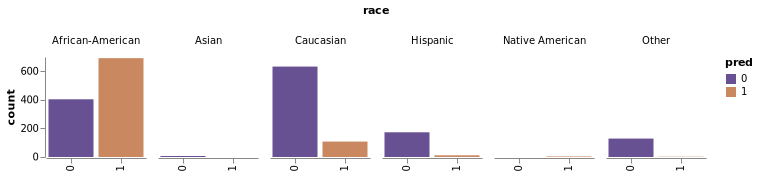

In [10]:
df_test |>
@vlplot(
    :bar,
    width=100,
    height=100,
    column="race:o",
    y={"count()", axis={title="count", grid=false}},
    x={"pred:n", axis={title=""}},
    color={"pred:n", scale={range=["#675193", "#ca8861"]}},
    spacing=10,
    config={
        view={stroke=:transparent},
        axis={domainWidth=1}
    }
)

### Fairness Metrics
Now we find the values of False Negative Rate, False Positive Rate, True Negative Rate and True Positive Rate. Values of other metrics like Equal Opportunity Score, etc can be calculated

In [12]:
for r in ["African-American", "Caucasian", "Hispanic"]
    indices = [x==r for x in df_test[:race]]
    ŷ = df_test[indices, :pred]
    ŷ = convert(CategoricalArray, ŷ)
    y_test = convert(CategoricalArray, y[test])
    println("Printing values for the race : ", r)
    println("False Negative Rate : ", false_negative_rate(ŷ, y_test[indices]))
    println("False Positive Rate : ", false_positive_rate(ŷ, y_test[indices]))
    println("True Negative Rate : ", true_negative_rate(ŷ, y_test[indices]))
    println("True Positive Rate : ", true_positive_rate(ŷ, y_test[indices]))
    println()
end

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[12]:2
└ @ Core In[12]:2


Printing values for the race : African-American
False Negative Rate : 0.2807017543859649
False Positive Rate : 0.5361216730038023
True Negative Rate : 0.46387832699619774
True Positive Rate : 0.7192982456140351

Printing values for the race : Caucasian
False Negative Rate : 0.819672131147541
False Positive Rate : 0.12155963302752293
True Negative Rate : 0.8784403669724771
True Positive Rate : 0.18032786885245902

Printing values for the race : Hispanic
False Negative Rate : 0.90625
False Positive Rate : 0.04958677685950408
True Negative Rate : 0.9504132231404959
True Positive Rate : 0.09375



┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/ashryaagr/.julia/packages/MLJBase/N04uL/src/measures/confusion_matrix.jl:83
┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/ashryaagr/.julia/packages/MLJBase/N04uL/src/measures/confusion_matrix.jl:83
┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/ashryaagr/.julia/packages/MLJBase/N04uL/src/measures/confusion_matrix.jl:83
┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/ashryaagr/.julia/packages/MLJBase/N04uL/src/measures/confusion_matrix.jl:83
┌ Warning: The classes are un-ordered,
│ using: nega

### Kindly ignore the above warnings. They aren't important and shall not be displayed in the tutorials as per the default configuration of Franklin

### Above analysis was performed on the sensitive attribute : race. Similar analysis could also be performed on the other protected attributes : Sex and Age